In [1]:
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time
from models import models as new_models
from utils import *
import keras
from keras_unet_collection import models, utils
import matplotlib.pyplot as plt
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

C:\Users\ak7550\AppData\Local\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow 2.10.1; Keras 2.10.0


## Constants, Parameters and Datasets

Length of the masked points: 12066
Size of the Training Dataset: 2240  
Size of the Validation Dataset: 240  
Training input shape: (1024, 1024, 1)
Training input values: [0. 1.]
Training output shape: (1024, 1024, 1) 
Validation input shape: (1024, 1024, 1)
Validation output shape: (1024, 1024, 1) 
Shape of the mask: (2, 1024, 1024)


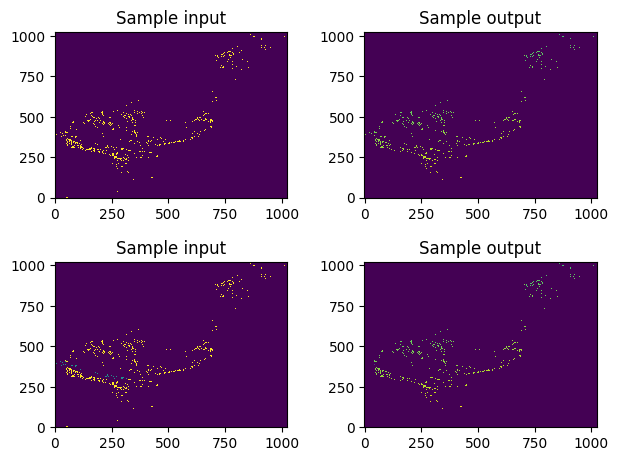

In [2]:
grid_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 2
split = 1
output_1d = False
EPOCHS = 200


MODEL_NAME = "Attn-Unet-pretrained"
LR = 0.00015
MIN_LR = LR/5
WARMUP_EPOCHS = 20

MODEL_NAME = "SWIN-Unet"
LR = 0.00018
MIN_LR = LR/6
WARMUP_EPOCHS = 20

MODEL_NAME = "CASPIAN"
LR = 0.0008
MIN_LR = LR/10
WARMUP_EPOCHS = 20


###### For Ablation studies ###########################

MODEL_NAME = "CASPIAN_beta_v4"
LR = 0.0008
MIN_LR = LR/10
WARMUP_EPOCHS = 20
version = 4
###### For Ablation studies ###########################


if not output_1d:
    #Loading and processing the mask
    the_mask = get_the_mask()


#Loading the dataset
ds = {
    'train': tf.data.Dataset.load("./data/train_ds_aug_split_%d" % split).map(lambda f,x,y,yf: tf.py_function(clear_ds, 
                                           inp=[f,x,y,yf, output_1d], 
                                           Tout=[tf.float32, tf.float32])),
    'val': tf.data.Dataset.load("./data/val_ds_aug_split_%d" % split).map(lambda f,x,y,yf: tf.py_function(clear_ds, 
                                           inp=[f,x,y,yf, output_1d], 
                                           Tout=[tf.float32, tf.float32]))
}

if "Attn" in MODEL_NAME:
    ds['train'] = ds['train'].map(lambda x,y: expand_input_channels(x, y))
    ds['val'] = ds['val'].map(lambda x,y: expand_input_channels(x, y))

print("Size of the Training Dataset: %d  " % tf.data.experimental.cardinality(ds["train"]).numpy())
print("Size of the Validation Dataset: %d  " % tf.data.experimental.cardinality(ds["val"]).numpy())
input_sample, label_sample = next(iter(ds["train"]))
print("Training input shape: %s" % str(input_sample.numpy().shape))
print("Training input values: %s" % str(np.unique(input_sample.numpy())))
print("Training output shape: %s " % str(label_sample.numpy().shape))
input_sample, label_sample = next(iter(ds["val"]))
print("Validation input shape: %s" % str(input_sample.numpy().shape))
print("Validation output shape: %s " % str(label_sample.numpy().shape))

samples = 2
fig, axs = plt.subplots(samples,2, facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .2, wspace=.13)
fig.tight_layout(pad=2, h_pad=2.5, w_pad=2.5)
axs = axs.ravel()
i = 0
for element in list(ds['train'].as_numpy_iterator())[:samples]: 
    x,y = element
    axs[i].imshow(x, origin="lower", interpolation='none', aspect='auto')
    axs[i].set_title("Sample input")
    i += 1
    axs[i].imshow(y, origin="lower", interpolation='none', aspect='auto')
    axs[i].set_title("Sample output")
    i += 1

ds['train'] = ds['train'].batch(batch_size)
ds['val'] = ds['val'].batch(batch_size)

the_mask = np.array([the_mask]*batch_size)
print ("Shape of the mask: %s" % str(the_mask.shape))

In [3]:
name = MODEL_NAME+"_split_{}_{}".format(str(split), time.strftime("%Y%m%d-%H%M%S"))

#TF Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='models/logs/{}'.format(name), histogram_freq=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint("./models/trained_models/%s/initial/" % MODEL_NAME, 
                    monitor="val_loss", mode="min", save_weights_only=True,
                    save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = EPOCHS//5)

steps_per_epoch = int(ds["train"].cardinality())#//batch_size
lr_schedule = LinearDecayPerEpoch(LR, steps_per_epoch, EPOCHS, MIN_LR)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=10, min_lr=MIN_LR)
first_decay_steps = steps_per_epoch*(EPOCHS//3)
cosine_lr_restarts = tf.keras.optimizers.schedules.CosineDecayRestarts(LR,first_decay_steps, t_mul=1.0, m_mul=0.8) 

# Compute the number of warmup batches
warmup_batches = WARMUP_EPOCHS * steps_per_epoch
# Create the Learning rate scheduler
warm_up_lr = WarmUpLearningRateScheduler(warmup_batches, init_lr=LR)

# Model Fitting
opt = tf.keras.optimizers.Adam(learning_rate=LR)
#opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#opt = tfa.optimizers.AdamW(learning_rate=init_lr, weight_decay=0.0005)

if "CASP" in MODEL_NAME:
    if "_" not in MODEL_NAME:
        model = new_models.CASPIAN(input_shape=(grid_size, grid_size, 1), filters=72, input_centering=True, 
                        depth=4, cardinality=34, activation='tanh', bottleneck_depth=8, 
                        init="glorot_normal", sup_level=1, compression_factor= 0.85, gr_level= 4)
    else:
        model = new_models.CASPIAN_beta(input_shape=(grid_size, grid_size, 1), filters=72, input_centering=True, 
                depth=4, cardinality=34, activation='tanh', bottleneck_depth=8, 
                init="glorot_normal", sup_level=1, compression_factor= 0.85, gr_level= 4, version=version)
elif "SWIN" in MODEL_NAME:
    set_seed()
    model = new_models.Swin_unet(
        filter_num_begin = 64, 
        depth = 4, 
        stack_num_down = 2, 
        stack_num_up = 2,
        patch_size = 8,  
        att_heads = 4,   
        input_centering=True,
        dropout = 0.0)
else:
    if "pretrained" in MODEL_NAME:
        model = models.att_unet_2d((1024, 1024, 3), filter_num=[32, 64, 128, 256], n_labels=1, 
                               stack_num_down=2, stack_num_up=2, activation='ReLU', 
                               atten_activation='ReLU', attention='add', output_activation='ReLU', 
                               batch_norm=False, pool=True, unpool=False,
                               backbone='VGG19', weights='imagenet', 
                               freeze_backbone=False, freeze_batch_norm=False, 
                               name='attunet')
    else:
        model = models.att_unet_2d((1024, 1024, 3), filter_num=[32, 64, 128, 256], n_labels=1, 
                               stack_num_down=2, stack_num_up=2, activation='ReLU', 
                               atten_activation='ReLU', attention='add', output_activation='ReLU', 
                               batch_norm=False, pool=True, unpool=False,
                               backbone='VGG19', weights=None, 
                               freeze_backbone=False, freeze_batch_norm=False, 
                               name='attunet')


if output_1d:
    model.compile(loss=tf.keras.losses.Huber(delta=0.5), optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(), "mae"])
else:
    model.compile(loss=custom_loss(mask=the_mask), optimizer=opt, metrics=[custom_rmse(mask=the_mask), custom_mae(mask=the_mask)])
model.summary()

history_warmup = model.fit(ds['train'],
                epochs=WARMUP_EPOCHS,
                validation_data=ds['val'],
                callbacks=[checkpoint, tensorboard_callback, warm_up_lr]) #PrintLearningRate()#reduce_lr#early_stop

model.load_weights("./models/trained_models/%s/initial/" % MODEL_NAME)
history = model.fit(ds['train'],
                epochs=EPOCHS,
                validation_data=ds['val'],
                callbacks=[checkpoint, tensorboard_callback, early_stop, reduce_lr]) #PrintLearningRate()#reduce_lr#early_stop

model.load_weights("./models/trained_models/%s/initial/" % MODEL_NAME)
model.save("./models/trained_models/"+MODEL_NAME+"_split_{}".format(str(split)), save_format='h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 1024, 1024,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 1024, 1024,   0           ['lambda[0][0]']                 
                                1)                                                            